Let's see if we can create a model to predict if a coin will
1. go up by 1%
2. trade in the same zone
3. go down by 1%
in the next 2 hours (12 5m candles)

on CDC exchange, fees are 0.4% per transaction, so we should aim to make at least 0.2% profit on each trade

In [85]:
import os
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, ShuffleSplit
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from ta.momentum import rsi
from ta.trend import sma_indicator
import xgboost as xgb


from cdc_wrapper import CDC

In [2]:
with open('keys.json', 'r') as f:
    keys = json.load(f)

cdc = CDC(keys, sandbox=False)

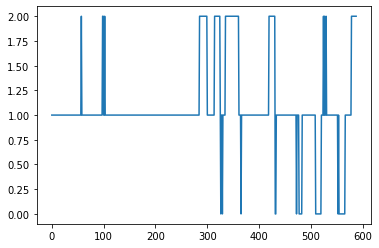

In [44]:
data = cdc.get_candlesticks('BTC_USDC', '5m', depth=1000)

df = pd.DataFrame.from_records(data)

future_window = 12
future_diff_threshold = 0.012

# convert our unix timestamp to dt
df['dt'] = pd.to_datetime(df['t'], unit='ms')

# calculate future values so we can set our labels
# will do feature engineering after this

future_cols = []
for i in range(1, future_window+1):
    df[f'h_{i}'] = df['h'].shift(-i)
    df[f'l_{i}'] = df['l'].shift(-i)
    future_cols.append(f'h_{i}')
    future_cols.append(f'l_{i}')

# drop the rows that will not have the full future values
df = df.iloc[:-future_window]

df['future_min'] = df.apply(lambda x: x[future_cols].min(), axis=1)
df['future_max'] = df.apply(lambda x: x[future_cols].max(), axis=1)

# can't think of how to decide if future_min came first or future_max came first
# so in the event that BOTH are more than 1% apart, will label as a "no difference"

df['min_flag'] = ((df['c'] - df['future_min']) / df['c']) > future_diff_threshold
df['max_flag'] = ((df['future_max'] - df['c']) / df['c']) > future_diff_threshold

df['label'] = 1
df.loc[(df['min_flag']==True)&(df['max_flag']==False), 'label'] = 0
df.loc[(df['min_flag']==False)&(df['max_flag']==True), 'label'] = 2
df.loc[(df['min_flag']==True)&(df['max_flag']==True), 'label'] = 1

df = df[['c', 'label']]

y = df['label'].values

plt.plot(y)

Let's focus on ETH USDC

In [ ]:
data_file_name = 'data3.csv'
instrument = 'BTC_USDC'
future_window = 12
future_diff_threshold = 0.012
past_window = 24 # 2 hours?

# technical analysis params
rsi_windows = [5, 7]
sma_windows = [5, 8, 13]

# load in and drop duplicates
df = pd.read_csv(data_file_name).drop_duplicates()

# we are streaming data in through the websocket so we only need the latest row 
df = df.groupby(['instrument', 't']).last().reset_index()

# filter for ETH USDC
df = df.loc[df['instrument']==instrument]

# convert our unix timestamp to dt
df['dt'] = pd.to_datetime(df['t'], unit='ms')

# calculate future values so we can set our labels
# will do feature engineering after this

future_cols = []
for i in range(1, future_window+1):
    df[f'h_{i}'] = df['h'].shift(-i)
    df[f'l_{i}'] = df['l'].shift(-i)
    future_cols.append(f'h_{i}')
    future_cols.append(f'l_{i}')

# drop the rows that will not have the full future values
df = df.iloc[:-future_window]

df['future_min'] = df.apply(lambda x: x[future_cols].min(), axis=1)
df['future_max'] = df.apply(lambda x: x[future_cols].max(), axis=1)

# can't think of how to decide if future_min came first or future_max came first
# so in the event that BOTH are more than 1% apart, will label as a "no difference"

df['min_flag'] = ((df['c'] - df['future_min']) / df['c']) > future_diff_threshold
df['max_flag'] = ((df['future_max'] - df['c']) / df['c']) > future_diff_threshold



df['label'] = 0
df.loc[(df['min_flag']==True)&(df['max_flag']==False), 'label'] = 1
df.loc[(df['min_flag']==False)&(df['max_flag']==True), 'label'] = 2
df.loc[(df['min_flag']==True)&(df['max_flag']==True), 'label'] = 0

# now that we have the labels, we can remove the future values and clean up a bit...

df = df[['dt', 'o', 'h', 'l', 'c', 'v', 'label']]

df = df.set_index('dt')

for w in rsi_windows:
    df[f'rsi{w}'] = rsi(df['c'], window=w)

for w in sma_windows:
    df[f'sma{w}'] = sma_indicator(df['c'], window=w)



X_cols = [col for col in df.columns if col != 'label']
# # let's bring in the past values

for i in range(1, past_window+1):
    for col in X_cols:
        df[f'{col}_{i}'] = df[col].shift(i)


# drop rows with NAs i.e. those that maybe be missing some indicators (due to the window) or past data
df = df.dropna()


# scaler = MinMaxScaler()
# X = df.drop(['dt', 'label'], axis=1).values
# y = df['label'].values

# scaler.fit(X)

# scaler.transform(X)

df

bot i want to build

1. websocket will eventually just keep streaming any number of pairs (for example, now it's just BTC_USDC, ETH_USDC, ETH_BTC, but should be able to just include any)
2. save the streamed data (into let's say CSVs, or maybe even GCP bucket?) but also the bot will be able to take in gaps in the training data (e.g. websocket is closed for 1 week for some reason)
3. should be able to create a bot for various pairs based on the data saved above
4. each bot can take in various parameters to decide indicators, window sizes, etc
5. maybe eventually try to automate (i.e. bot will loop through various parameters to find the one that can produce the best model and by extension strategy)


But anyway for the model building

1. Read in data
2. Initial preprocessing - all up until labelling
3. Train test split?
4. Pipeline
- feature engineering and scaling etc
 

In [116]:
def initial_preprocessing(df, future_window, future_diff_threshold, allow_overlap=False, random_state=None):
    """Takes in a df with columns [instrument, t, o, h, l, c, v] and returns it with labels based on future numbers.
    Label can be [0, 1, 2] where 1 means that within future_window time points in the future, the price went below (latest closing price * (1-future_diff_threshold)).
    2 means that within future_window time points in the future, the price went above (latest closing price * (1+future_diff_threshold))
    0 means neither of the above (latest closing price stayed within +- future_diff threshold)

    If there are gaps between data, such as (assuming 5 min candles) one row ending at 00:05am and the next one starting at 00:15am (and not 00:10am), future windows will not be calculated across the gap.
    That also means that chunks of data smaller than future_window will probably be discarded
    Gaps determined based on MIN of distance between rows. e.g. if the smallest interval is 5 mins, then 5 mins will be the stardard, anything else will be the gap 

    If allow_overlap is False, will drop rows that overlap each other.
    For instance, (assuming 5 min candles) a row that starts from 00:00am with 5 future windows (25 mins into the future) will overlap with a row that starts from 00:15am

    random_state will allow seeding of numpy random generator (is reset before the function returns)
    """

    # drop duplicates because the websocket just gets data every 30s, a lot of repeated data
    df = df.drop_duplicates()

    #  multiple instruments in there, so group by
    # also because of repeated data inflow, only want the last time for each instrument/time combi
    df = df.groupby(['instrument', 't']).last().reset_index()
    df['dt'] = pd.to_datetime(df['t'], unit='ms')

    # separate df into different instruments
    dfs = []
    for instrument in df['instrument'].unique():
        dfs.append(df.loc[df['instrument']==instrument].copy())

    # instrument level
    final_dfs = []
    for sub_df in dfs:

        sub_df = sub_df.sort_values('dt')
        sub_df['dt_diff'] = sub_df['dt'].diff()
        dt_diff_min = sub_df['dt_diff'].min()
        sub_df['dt_diff_check'] = sub_df['dt_diff'] == dt_diff_min
        sub_df = sub_df.reset_index()

        # get indexes where dt_diff_check is False
        # it's the start of a new sub_df (after the gap)
        new_sub_df_indexes = sub_df.loc[~sub_df['dt_diff_check']].index.tolist()
        sub_sub_dfs = []
        for i, index in enumerate(new_sub_df_indexes):
            # if there's only one value, then the whole thing is the sub sub df
            if len(new_sub_df_indexes) == 1:
                sub_sub_df = sub_df.iloc[index:]
                sub_sub_dfs.append(sub_sub_df.copy())
            # whereas if it's the last value, then it's that til the end
            elif i == len(new_sub_df_indexes) - 1:
                sub_sub_df = sub_df.iloc[index:]
                sub_sub_dfs.append(sub_sub_df.copy())
            # otherwise, stop before next value in list
            else:
                sub_sub_df = sub_df.iloc[index:new_sub_df_indexes[i+1]]
                sub_sub_dfs.append(sub_sub_df.copy())

        # for sub_sub_df in sub_sub_dfs:
        #     print(sub_sub_df.head())

        

        for sub_sub_df in sub_sub_dfs:
            
            # simply throw out sub_sub_dfs that cannot even get the future window
            if len(sub_sub_df) > future_window:

                sub_sub_df['future_max'] = sub_sub_df['h'].iloc[::-1].rolling(future_window+1).max().iloc[::-1]
                sub_sub_df['future_min'] = sub_sub_df['l'].iloc[::-1].rolling(future_window+1).min().iloc[::-1]
                sub_sub_df = sub_sub_df.loc[~sub_sub_df['future_max'].isna()].copy()
                sub_sub_df['min_flag'] = ((sub_sub_df['c'] - sub_sub_df['future_min']) / sub_sub_df['c']) > future_diff_threshold
                sub_sub_df['max_flag'] = ((sub_sub_df['future_max'] - sub_sub_df['c']) / sub_sub_df['c']) > future_diff_threshold
                sub_sub_df['label'] = 0
                sub_sub_df.loc[(sub_sub_df['min_flag']==True)&(sub_sub_df['max_flag']==False), 'label'] = 1
                sub_sub_df.loc[(sub_sub_df['min_flag']==False)&(sub_sub_df['max_flag']==True), 'label'] = 2
                sub_sub_df.loc[(sub_sub_df['min_flag']==True)&(sub_sub_df['max_flag']==True), 'label'] = 0
                
                    
            sub_sub_df['temp_index'] = sub_sub_df.index + 1

            sub_sub_df['temp_index_2'] = sub_sub_df['temp_index'] % random_choice

            sub_sub_df = sub_sub_df.loc[sub_sub_df['temp_index_2']==0].copy()
            sub_sub_df = sub_sub_df[['instrument', 'dt', 'o', 'h', 'l', 'c', 'v', 'label']]

            final_dfs.append(sub_sub_df)

    df = pd.concat(final_dfs, axis=0)

    

    return df

def basic_feature_engineering(df, future_window, past_window, remove_overlap=True, random_state=None):
    """Takes in a initially preprocessed df (run through the initial_preprocessing function) and
    does basic feature engineering of adding past windows, as well as removing overlap
    """
    np.random.seed(random_state)
    random_choice = np.random.choice(future_window)
    print('random choice:', random_choice)

    np.random.seed()
    

In [119]:
data_file_name = 'data3.csv'
instrument = 'ETH_USDC'
future_window = 12
future_diff_threshold = 0.012
past_window = 24 # 2 hours?

data_filenames = [filename for filename in os.listdir() if filename.startswith('data') and filename.endswith('.csv')]

dfs = []

for filename in data_filenames:
    df = pd.read_csv(filename)
    dfs.append(df)

df = pd.concat(dfs)

df = initial_preprocessing(df, future_window=future_window, future_diff_threshold=future_diff_threshold, random_state=1)

df


random choice: 5
random choice: 11
random choice: 8


,instrument,dt,o,h,l,c,v,label
4,BTC_USDC,2022-07-08 10:10:00,21525.12,21532.60,21477.89,21503.15,1.374789,0
9,BTC_USDC,2022-07-08 10:35:00,21660.26,21660.70,21623.08,21655.91,1.133252,0
14,BTC_USDC,2022-07-08 11:00:00,21526.80,21535.30,21496.66,21496.66,1.045665,0
19,BTC_USDC,2022-07-08 11:25:00,21601.18,21601.93,21562.72,21579.20,0.848419,0
24,BTC_USDC,2022-07-08 11:50:00,21630.63,21638.96,21594.25,21604.20,0.457086,1
...,...,...,...,...,...,...,...,...
9415,ETH_USDC,2022-08-11 11:55:00,1907.02,1910.02,1901.71,1903.05,17.627600,2
9423,ETH_USDC,2022-08-11 12:35:00,1915.36,1930.15,1912.14,1927.22,45.748630,1
9431,ETH_USDC,2022-08-11 13:15:00,1912.65,1914.54,1907.23,1908.30,25.856500,0
9439,ETH_USDC,2022-08-11 13:55:00,1915.01,1915.01,1909.70,1912.57,15.097300,1


In [111]:
1 % 5

1

In [30]:
np.random.seed(seed=1)

print(np.random.randn(1))

[1.62434536]


In [8]:
# the objective above sounds fancy but let's focus on teh model building part first

data_file_name = 'data3.csv'
instrument = 'ETH_USDC'
future_window = 12
future_diff_threshold = 0.012
past_window = 24 # 2 hours?

# technical analysis params
rsi_windows = [5, 7]
sma_windows = [5, 8, 13]

# this will not go into the formal sklearn pipeline
# it's just to get labels

# load in and drop duplicates
df = pd.read_csv(data_file_name).drop_duplicates()


# we are streaming data in through the websocket so we only need the latest row 
df = df.groupby(['instrument', 't']).last().reset_index()

# # filter for selected instrument
# df = df.loc[df['instrument']==instrument]

# convert our unix timestamp to dt
df['dt'] = pd.to_datetime(df['t'], unit='ms')

# # calculate future values so we can set our labels

future_cols = []
for i in range(1, future_window+1):
    df[f'h_{i}'] = df['h'].shift(-i)
    df[f'l_{i}'] = df['l'].shift(-i)
    future_cols.append(f'h_{i}')
    future_cols.append(f'l_{i}')

# drop the rows that will not have the full future values
df = df.iloc[:-future_window]

df['future_min'] = df.apply(lambda x: x[future_cols].min(), axis=1)
df['future_max'] = df.apply(lambda x: x[future_cols].max(), axis=1)

# can't think of how to decide if future_min came first or future_max came first
# so in the event that BOTH are more than 1% apart, will label as a "no difference"

df['min_flag'] = ((df['c'] - df['future_min']) / df['c']) > future_diff_threshold
df['max_flag'] = ((df['future_max'] - df['c']) / df['c']) > future_diff_threshold

df['label'] = 0
df.loc[(df['min_flag']==True)&(df['max_flag']==False), 'label'] = 1
df.loc[(df['min_flag']==False)&(df['max_flag']==True), 'label'] = 2
df.loc[(df['min_flag']==True)&(df['max_flag']==True), 'label'] = 0

# now that we have the labels, we can remove the future values and clean up a bit...

df = df[['instrument', 'dt', 'o', 'h', 'l', 'c', 'v', 'label']]

df

,instrument,dt,o,h,l,c,v,label
0,BTC_USDC,2022-07-14 16:05:00,20456.47,20456.47,20313.42,20332.95,2.315713,0
1,BTC_USDC,2022-07-14 16:10:00,20327.80,20327.80,20256.51,20309.54,2.468612,0
2,BTC_USDC,2022-07-14 16:15:00,20314.54,20343.00,20300.00,20306.57,0.409806,0
3,BTC_USDC,2022-07-14 16:20:00,20300.00,20342.28,20295.20,20327.80,0.776171,0
4,BTC_USDC,2022-07-14 16:25:00,20315.94,20328.77,20226.67,20245.97,1.009384,2
...,...,...,...,...,...,...,...,...
13798,ETH_USDC,2022-07-30 14:25:00,1727.18,1727.21,1723.77,1725.86,0.053910,0
13799,ETH_USDC,2022-07-30 14:30:00,1724.97,1725.75,1718.10,1722.21,0.903070,0
13800,ETH_USDC,2022-07-30 14:35:00,1720.53,1722.08,1714.75,1718.50,5.085740,2
13801,ETH_USDC,2022-07-30 14:40:00,1719.64,1721.13,1718.74,1720.82,1.501320,0


In [ ]:
# the objective above sounds fancy but let's focus on teh model building part first

data_file_name = 'data3.csv'
instrument = 'BTC_USDC'
future_window = 12
future_diff_threshold = 0.012
past_window = 24 # 2 hours?

# technical analysis params
rsi_windows = [5, 7]
sma_windows = [5, 8, 13]

# this will not go into the formal sklearn pipeline
# it's just to get labels

# load in and drop duplicates
df = pd.read_csv(data_file_name).drop_duplicates()

# we are streaming data in through the websocket so we only need the latest row 
df = df.groupby(['instrument', 't']).last().reset_index()

# filter for selected instrument
df = df.loc[df['instrument']==instrument]

# convert our unix timestamp to dt
df['dt'] = pd.to_datetime(df['t'], unit='ms')

# calculate future values so we can set our labels

future_cols = []
for i in range(1, future_window+1):
    df[f'h_{i}'] = df['h'].shift(-i)
    df[f'l_{i}'] = df['l'].shift(-i)
    future_cols.append(f'h_{i}')
    future_cols.append(f'l_{i}')

# drop the rows that will not have the full future values
df = df.iloc[:-future_window]

df['future_min'] = df.apply(lambda x: x[future_cols].min(), axis=1)
df['future_max'] = df.apply(lambda x: x[future_cols].max(), axis=1)

# can't think of how to decide if future_min came first or future_max came first
# so in the event that BOTH are more than 1% apart, will label as a "no difference"

df['min_flag'] = ((df['c'] - df['future_min']) / df['c']) > future_diff_threshold
df['max_flag'] = ((df['future_max'] - df['c']) / df['c']) > future_diff_threshold

df['label'] = 0
df.loc[(df['min_flag']==True)&(df['max_flag']==False), 'label'] = 1
df.loc[(df['min_flag']==False)&(df['max_flag']==True), 'label'] = 2
df.loc[(df['min_flag']==True)&(df['max_flag']==True), 'label'] = 0

# now that we have the labels, we can remove the future values and clean up a bit...

df = df[['dt', 'o', 'h', 'l', 'c', 'v', 'label']]

df

will need to kfold because rows near to each other might be highly correlated??

[0]	train-mlogloss:0.99811	test-mlogloss:1.02918
[1]	train-mlogloss:0.90991	test-mlogloss:0.96659
[2]	train-mlogloss:0.83469	test-mlogloss:0.91508
[3]	train-mlogloss:0.76711	test-mlogloss:0.86523
[4]	train-mlogloss:0.70848	test-mlogloss:0.82147
[0]	train-mlogloss:0.99961	test-mlogloss:1.04427
[1]	train-mlogloss:0.90630	test-mlogloss:0.98915
[2]	train-mlogloss:0.83289	test-mlogloss:0.95129


c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[3]	train-mlogloss:0.76341	test-mlogloss:0.90634
[4]	train-mlogloss:0.70023	test-mlogloss:0.86696
[0]	train-mlogloss:0.99659	test-mlogloss:1.04082
[1]	train-mlogloss:0.90868	test-mlogloss:0.98989
[2]	train-mlogloss:0.83194	test-mlogloss:0.94548
[3]	train-mlogloss:0.76253	test-mlogloss:0.90361
[4]	train-mlogloss:0.70192	test-mlogloss:0.85853
[0]	train-mlogloss:0.99316	test-mlogloss:1.04156
[1]	train-mlogloss:0.90229	test-mlogloss:0.99055
[2]	train-mlogloss:0.82605	test-mlogloss:0.95079
[3]	train-mlogloss:0.75812	test-mlogloss:0.91321
[4]	train-mlogloss:0.69864	test-mlogloss:0.87901
[0]	train-mlogloss:0.99462	test-mlogloss:1.03292
[1]	train-mlogloss:0.90564	test-mlogloss:0.97581
[2]	train-mlogloss:0.82544	test-mlogloss:0.92620
[3]	train-mlogloss:0.75547	test-mlogloss:0.88039
[4]	train-mlogloss:0.69178	test-mlogloss:0.83804
[0]	train-mlogloss:0.99228	test-mlogloss:1.03173
[1]	train-mlogloss:0.90415	test-mlogloss:0.98010
[2]	train-mlogloss:0.83214	test-mlogloss:0.94051
[3]	train-mlogloss:0

c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[3]	train-mlogloss:0.77346	test-mlogloss:0.87842
[4]	train-mlogloss:0.71191	test-mlogloss:0.83542
[0]	train-mlogloss:0.99376	test-mlogloss:1.04519
[1]	train-mlogloss:0.90512	test-mlogloss:1.00306
[2]	train-mlogloss:0.82790	test-mlogloss:0.96538
[3]	train-mlogloss:0.75870	test-mlogloss:0.92630
[4]	train-mlogloss:0.69506	test-mlogloss:0.88715
[0]	train-mlogloss:0.99614	test-mlogloss:1.03227
[1]	train-mlogloss:0.90656	test-mlogloss:0.97210
[2]	train-mlogloss:0.83203	test-mlogloss:0.92102
[3]	train-mlogloss:0.76697	test-mlogloss:0.87815
[4]	train-mlogloss:0.69804	test-mlogloss:0.82337
[0]	train-mlogloss:0.99415	test-mlogloss:1.03616
[1]	train-mlogloss:0.90621	test-mlogloss:0.98619
[2]	train-mlogloss:0.82970	test-mlogloss:0.94610
[3]	train-mlogloss:0.76070	test-mlogloss:0.90435
[4]	train-mlogloss:0.69791	test-mlogloss:0.86941
[0]	train-mlogloss:0.99356	test-mlogloss:1.03132
[1]	train-mlogloss:0.90479	test-mlogloss:0.97632
[2]	train-mlogloss:0.82822	test-mlogloss:0.93065
[3]	train-mlogloss:0

c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[2]	train-mlogloss:0.83626	test-mlogloss:0.95335
[3]	train-mlogloss:0.76741	test-mlogloss:0.91195
[4]	train-mlogloss:0.70832	test-mlogloss:0.87779
[0]	train-mlogloss:0.99947	test-mlogloss:1.04869
[1]	train-mlogloss:0.90865	test-mlogloss:0.99893
[2]	train-mlogloss:0.82919	test-mlogloss:0.95410
[3]	train-mlogloss:0.76350	test-mlogloss:0.92223
[4]	train-mlogloss:0.69765	test-mlogloss:0.88579
[0]	train-mlogloss:1.01020	test-mlogloss:1.04779
[1]	train-mlogloss:0.91983	test-mlogloss:0.98210
[2]	train-mlogloss:0.83868	test-mlogloss:0.92367
[3]	train-mlogloss:0.77363	test-mlogloss:0.87574
[4]	train-mlogloss:0.71086	test-mlogloss:0.83449
[0]	train-mlogloss:0.99620	test-mlogloss:1.02808
[1]	train-mlogloss:0.90335	test-mlogloss:0.97009
[2]	train-mlogloss:0.82468	test-mlogloss:0.92045
[3]	train-mlogloss:0.75463	test-mlogloss:0.87849
[4]	train-mlogloss:0.69657	test-mlogloss:0.84284
[0]	train-mlogloss:0.99602	test-mlogloss:1.03531
[1]	train-mlogloss:0.91654	test-mlogloss:0.98591
[2]	train-mlogloss:0

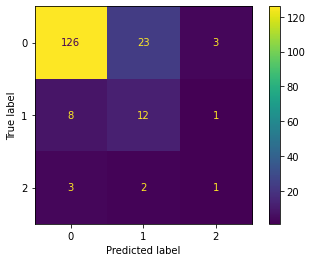

[0]	final-mlogloss:0.98388
[1]	final-mlogloss:0.88432
[2]	final-mlogloss:0.79825
[3]	final-mlogloss:0.72400
[4]	final-mlogloss:0.65432


c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


In [88]:
# balance classes

df2 = df.copy()

scaler = MinMaxScaler()

X_cols = [col for col in df2.columns if col != 'label']
y_col = 'label'

X = df2[X_cols]
y = df2[y_col]

X = scaler.fit_transform(X)

param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['nthread'] = 6
param['num_class'] = 3

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.33, random_state=0
# )

rskf = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=0)

error_rates = []

for train_index, test_index in rskf.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train
    )

    xg_train = xgb.DMatrix(X_train, label=y_train, weight=weights)
    xg_test = xgb.DMatrix(X_test, label=y_test)

    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 5
    bst = xgb.train(param, xg_train, num_round, watchlist)
    # get prediction
    pred = bst.predict(xg_test)
    error_rate = np.sum(pred != y_test) / y_test.shape[0]
    error_rates.append(error_rate)
    # print('Test error using softmax = {}'.format(error_rate))

print('Overall mean error rate:', np.mean(error_rates))

cm = ConfusionMatrixDisplay(confusion_matrix(y_test, pred))
cm.plot()
plt.show()

# will use train test split for convenience
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=np.round(1/6, 2), random_state=0
)



weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_test
)

xg = xgb.DMatrix(X_test, label=y_test, weight=weights)
watchlist = [(xg, 'final')]
num_round=5
bst = xgb.train(param, xg, num_round, watchlist)

In [89]:
windows = max(rsi_windows + sma_windows)

testing_data = cdc.get_candlesticks(instrument_name=instrument, time_frame='5m', depth=windows+future_window+past_window)

testing_df = pd.DataFrame.from_records(testing_data)

testing_df['dt'] = pd.to_datetime(testing_df['t'], unit='ms')
results_df = testing_df.copy()[-future_window:]
print(results_df['l'].min(), results_df['h'].max())
testing_df = testing_df[:-future_window]



testing_df = testing_df.set_index('dt')
testing_df = testing_df.drop('t', axis=1)

for w in rsi_windows:
    testing_df[f'rsi{w}'] = rsi(testing_df['c'], window=w)

for w in sma_windows:
    testing_df[f'sma{w}'] = sma_indicator(testing_df['c'], window=w)



X_cols = [col for col in testing_df.columns if col != 'label']
# # let's bring in the past values

dfs = [testing_df]

for i in range(1, past_window+1):

    dataframe = testing_df.copy().shift(i)
    new_cols = [f'{col}_{i}' for col in dataframe.columns]
    dataframe.columns = new_cols
    dfs.append(dataframe)
    # for col in X_cols:
    #     testing_df[f'{col}_{i}'] = testing_df[col].shift(i)

testing_df = pd.concat(dfs, axis=1)

testing_df

# drop rows with NAs i.e. those that maybe be missing some indicators (due to the window) or past data
testing_df = testing_df.dropna()

X = testing_df

X = scaler.transform(X)

X = xgb.DMatrix(X)

bst.predict(X)

19649.37 19900.99


array([0.], dtype=float32)

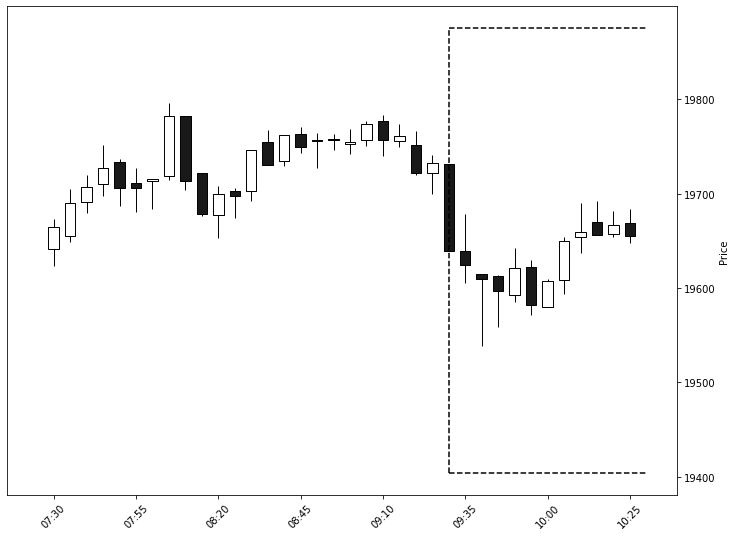

In [77]:
testing_data = cdc.get_candlesticks(instrument_name=instrument, time_frame='5m', depth=future_window+past_window)

testing_df = pd.DataFrame.from_records(testing_data)

testing_df['dt'] = pd.to_datetime(testing_df['t'], unit='ms')

testing_df = testing_df.drop('t', axis=1).set_index('dt').rename({'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume'}, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(12,9))

mpl.plot(
    testing_df,
    type='candle',
    style='classic',
    ax=ax
)

plt.sca(ax)

vline_y_min = min(testing_df.iloc[past_window]['Close']*(1-future_diff_threshold), testing_df['Low'].min())
vline_y_max = max(testing_df.iloc[past_window]['Close']*(1+future_diff_threshold), testing_df['High'].max())

plt.vlines(x=past_window, ymin=vline_y_min, ymax=vline_y_max, colors='black', linestyles='dashed')
plt.hlines(y=testing_df.iloc[past_window]['Close']*(1+future_diff_threshold), xmin=past_window, xmax=past_window+future_window, colors='black', linestyles='dashed')
plt.hlines(y=testing_df.iloc[past_window]['Close']*(1-future_diff_threshold), xmin=past_window, xmax=past_window+future_window, colors='black', linestyles='dashed')

plt.show()